# Grid results exploration

Parse `grid_results.md`, export two CSVs, and plot MSE metrics by `train_batch` and `lambda_w` using seaborn.


In [57]:
import matplotlib as mpl
import os
import shutil

# This finds the cache directory and deletes it
cache_dir = mpl.get_cachedir()
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print(f"Cache cleared at: {cache_dir}")
else:
    print("No cache directory found.")


No cache directory found.


In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(
    style="whitegrid",
    context="talk",
    font="Arial",
    rc={
        "axes.facecolor": "#f9fafb",
        "grid.color": "#e5e7eb",
        "axes.edgecolor": "#d1d5db",
    },
)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300


In [59]:
md_path = Path("grid_results.md")
table_blocks = md_path.read_text().strip().split("\n\n")
table1_md, table2_md = table_blocks[:2]

def parse_md_table(md_block: str) -> pd.DataFrame:
    lines = [ln.strip() for ln in md_block.strip().splitlines() if ln.strip()]
    header = [col.strip() for col in lines[0].strip('|').split('|')]
    rows = [[col.strip() for col in ln.strip('|').split('|')] for ln in lines[2:]]
    return pd.DataFrame(rows, columns=header)

def split_mean_sd(df: pd.DataFrame, cols):
    for col in cols:
        extracted = df[col].str.extract(r"([0-9.]+)\(([0-9.]+)\)")
        df[f"{col}_mean"] = extracted[0].astype(float)
        df[f"{col}_sd"] = extracted[1].astype(float)
    return df

numeric_cols = ["train_batch", "lambda_w", "noise_dim"]

table1 = parse_md_table(table1_md)
table1[numeric_cols] = table1[numeric_cols].apply(pd.to_numeric)
table1 = split_mean_sd(table1, ["L1", "L2", "MSE_mean", "MSE_sd"])

table2 = parse_md_table(table2_md)
table2[numeric_cols] = table2[numeric_cols].apply(pd.to_numeric)
quantile_cols = table2.columns[3:]
table2 = split_mean_sd(table2, quantile_cols)

table1.to_csv("grid_results_table1.csv", index=False)
table2.to_csv("grid_results_table2.csv", index=False)

noise_values = sorted(table1["noise_dim"].unique())
batch_values = sorted(table1["train_batch"].unique())
noise_levels = noise_values
noise_palette = {nd: sns.color_palette("Set2", n_colors=len(noise_values))[i] for i, nd in enumerate(noise_values)}
batch_palette = {val: sns.color_palette("tab10", n_colors=len(batch_values))[i] for i, val in enumerate(batch_values)}

table1.head()


train_batch  lambda_w  noise_dim            L1            L2      MSE_mean  \
0         5000       0.0          1  1.265(0.035)  3.937(0.509)  0.745(0.325)   
1         5000       0.2          1  1.275(0.039)  3.957(0.528)  0.764(0.325)   
2         5000       0.5          1  1.280(0.040)  3.983(0.564)  0.798(0.342)   
3         5000       0.9          1  1.296(0.026)  4.135(0.582)  0.955(0.393)   
4         5000       1.0          1  1.920(0.113)  8.130(1.192)  5.159(0.811)   

         MSE_sd  L1_mean  L1_sd  L2_mean  L2_sd  MSE_mean_mean  MSE_mean_sd  \
0  0.875(0.061)    1.265  0.035    3.937  0.509          0.745        0.325   
1  0.384(0.071)    1.275  0.039    3.957  0.528          0.764        0.325   
2  0.408(0.242)    1.280  0.040    3.983  0.564          0.798        0.342   
3  0.420(0.106)    1.296  0.026    4.135  0.582          0.955        0.393   
4  0.757(0.230)    1.920  0.113    8.130  1.192          5.159        0.811   

   MSE_sd_mean  MSE_sd_sd  
0        0.875      0.061  
1        0.384      0.071  
2        0.408      0.242  
3        0.420      0.106  
4        0.757      0.230

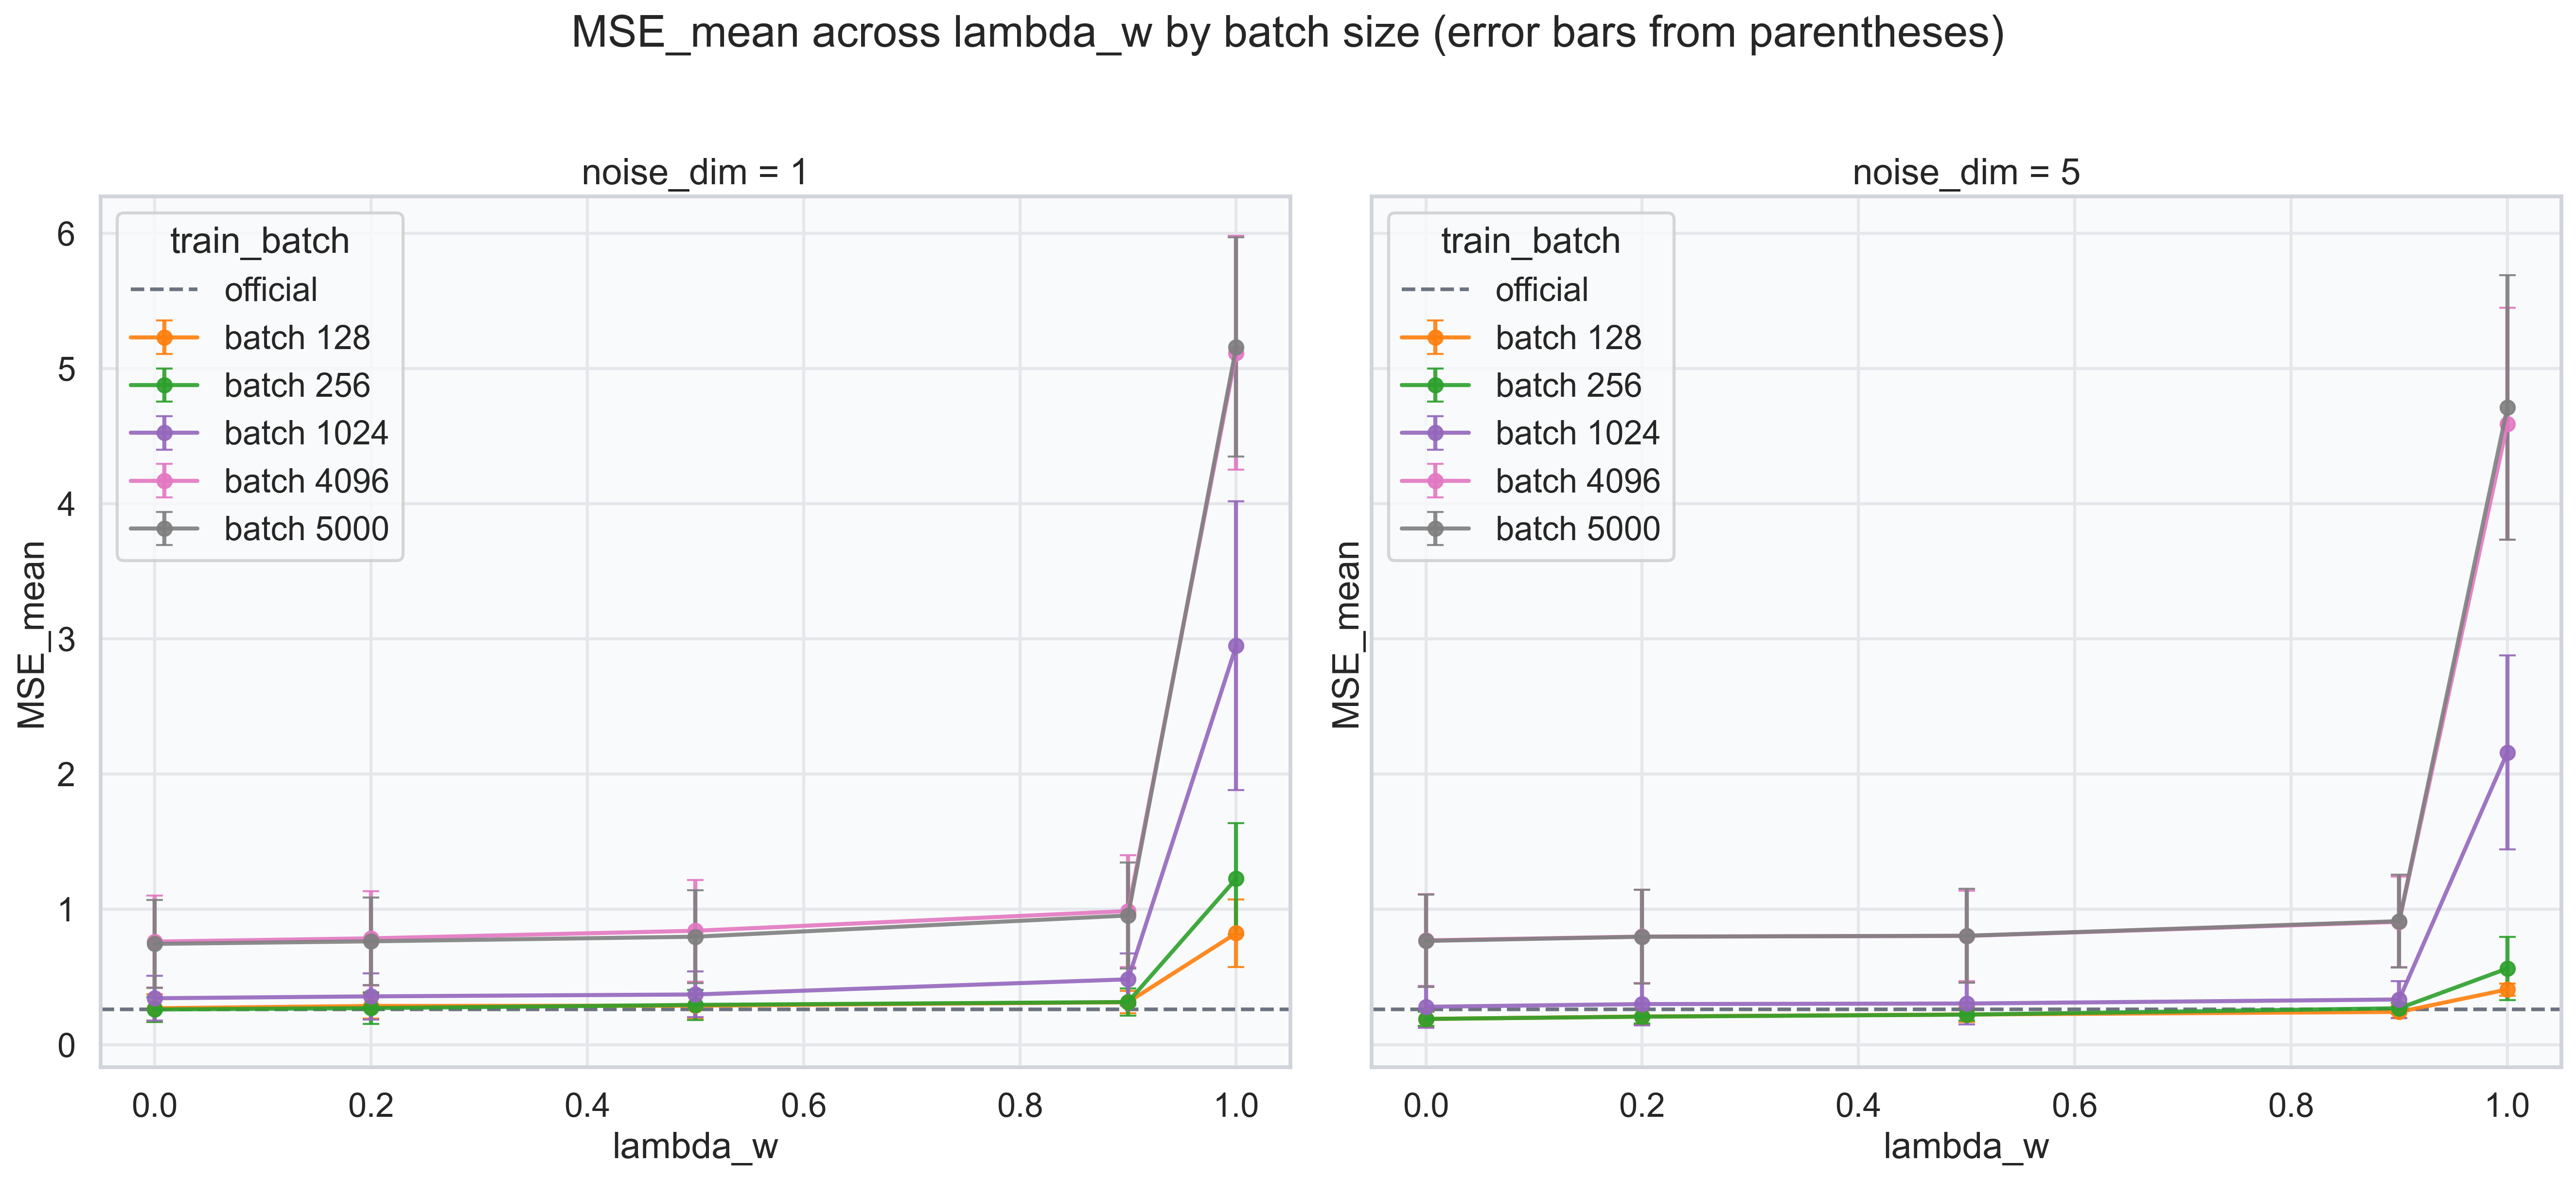

In [72]:
noise_levels = sorted(table1["noise_dim"].unique())
fig, axes = plt.subplots(1, len(noise_levels), figsize=(18, 8), sharey=True, dpi=300)
axes = axes if len(noise_levels) > 1 else [axes]

official_mse_mean = 0.26

for ax, nd in zip(axes, noise_levels):
    subset = table1[table1["noise_dim"] == nd]
    for i, (batch, sub) in enumerate(subset.groupby("train_batch")):
        if batch in [64, 512, 2048]:
            continue
        color = batch_palette.get(batch)
        ax.errorbar(
            sub["lambda_w"],
            sub["MSE_mean_mean"],
            yerr=sub["MSE_mean_sd"],
            marker="o",
            linestyle="-",
            lw=2,
            markersize=7,
            capsize=4,
            alpha=0.9,
            color=color,
            label=f"batch {int(batch)}",
        )
    ax.axhline(official_mse_mean, linestyle="--", color="#6b7280", lw=1.8, label="official")
    ax.set_title(f"noise_dim = {nd:.0f}")
    ax.set_xlabel("lambda_w")
    ax.set_ylabel("MSE_mean")
    ax.legend(title="train_batch")

fig.suptitle("MSE_mean across lambda_w by batch size (error bars from parentheses)", y=1.02)
plt.tight_layout()


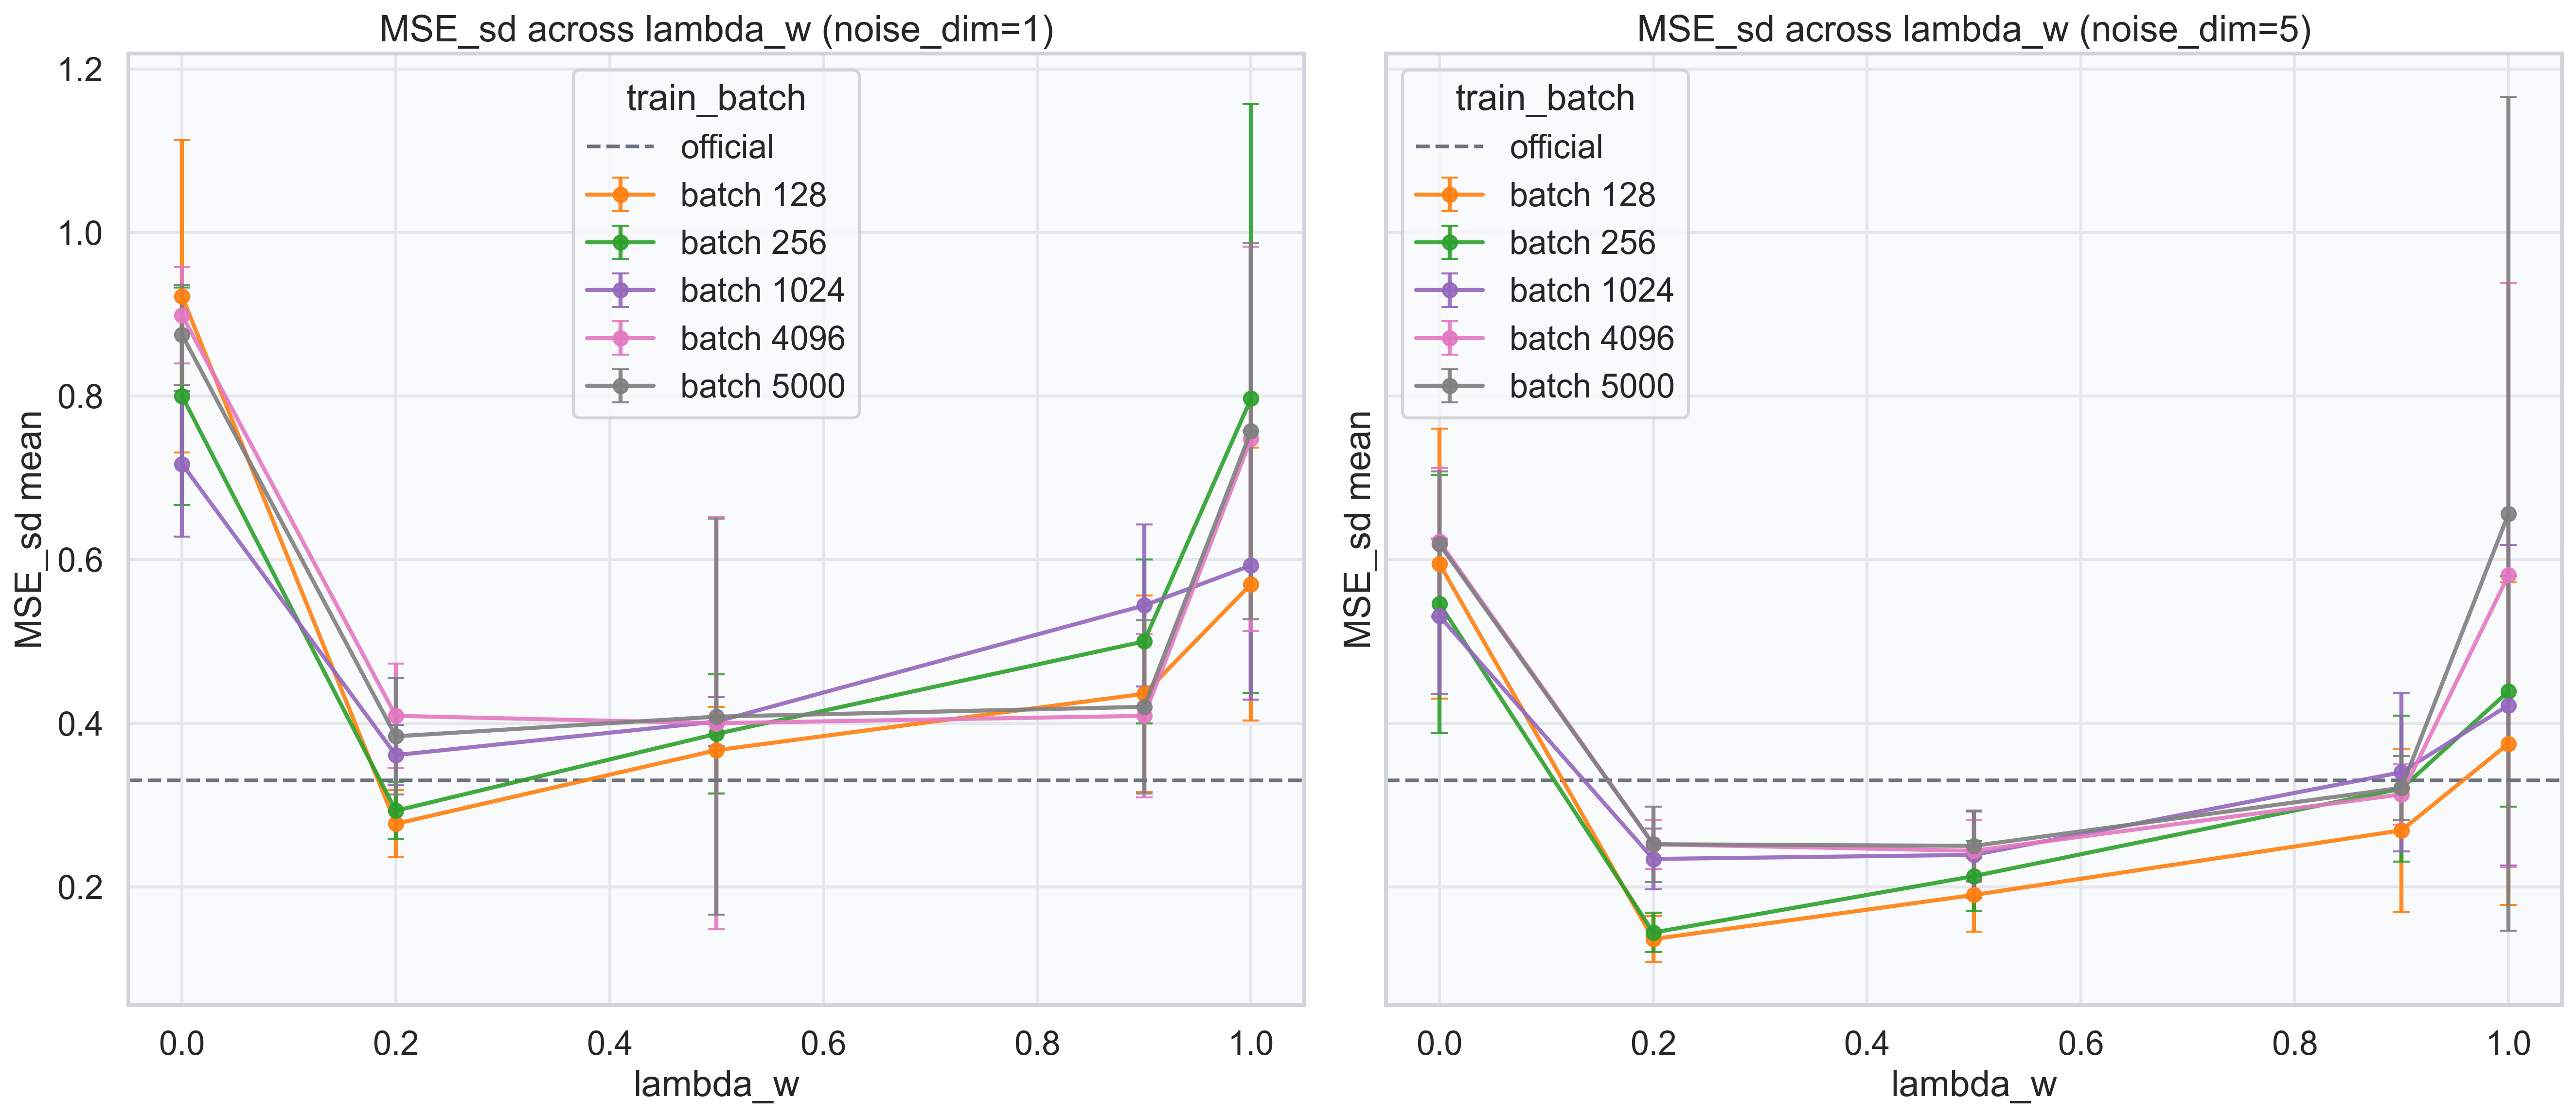

In [73]:
noise_levels = sorted(table1["noise_dim"].unique())
fig, axes = plt.subplots(1, len(noise_levels), figsize=(18, 8), sharey=True)
axes = axes if len(noise_levels) > 1 else [axes]

official_mse_sd = 0.33

for ax, nd in zip(axes, noise_levels):
    subset = table1[table1["noise_dim"] == nd]
    for i, (batch, sub) in enumerate(subset.groupby("train_batch")):
        if batch in [64, 512, 2048]:
            continue
        color = batch_palette.get(batch)
        ax.errorbar(
            sub["lambda_w"],
            sub["MSE_sd_mean"],
            yerr=sub["MSE_sd_sd"],
            marker="o",
            linestyle="-",
            lw=2,
            markersize=7,
            capsize=4,
            alpha=0.9,
            color=color,
            label=f"batch {int(batch)}",
        )
    ax.axhline(official_mse_sd, linestyle="--", color="#6b7280", lw=1.8, label="official")
    ax.set_title(f"MSE_sd across lambda_w (noise_dim={nd:.0f})")
    ax.set_xlabel("lambda_w")
    ax.set_ylabel("MSE_sd mean")
    ax.legend(title="train_batch")

plt.tight_layout()


## L1 and L2 vs batch size (lambda_w = 0.2)
Filter to lambda_w=0.2 and plot L1/L2 means with their std as error bars across train_batch for each noise_dim.


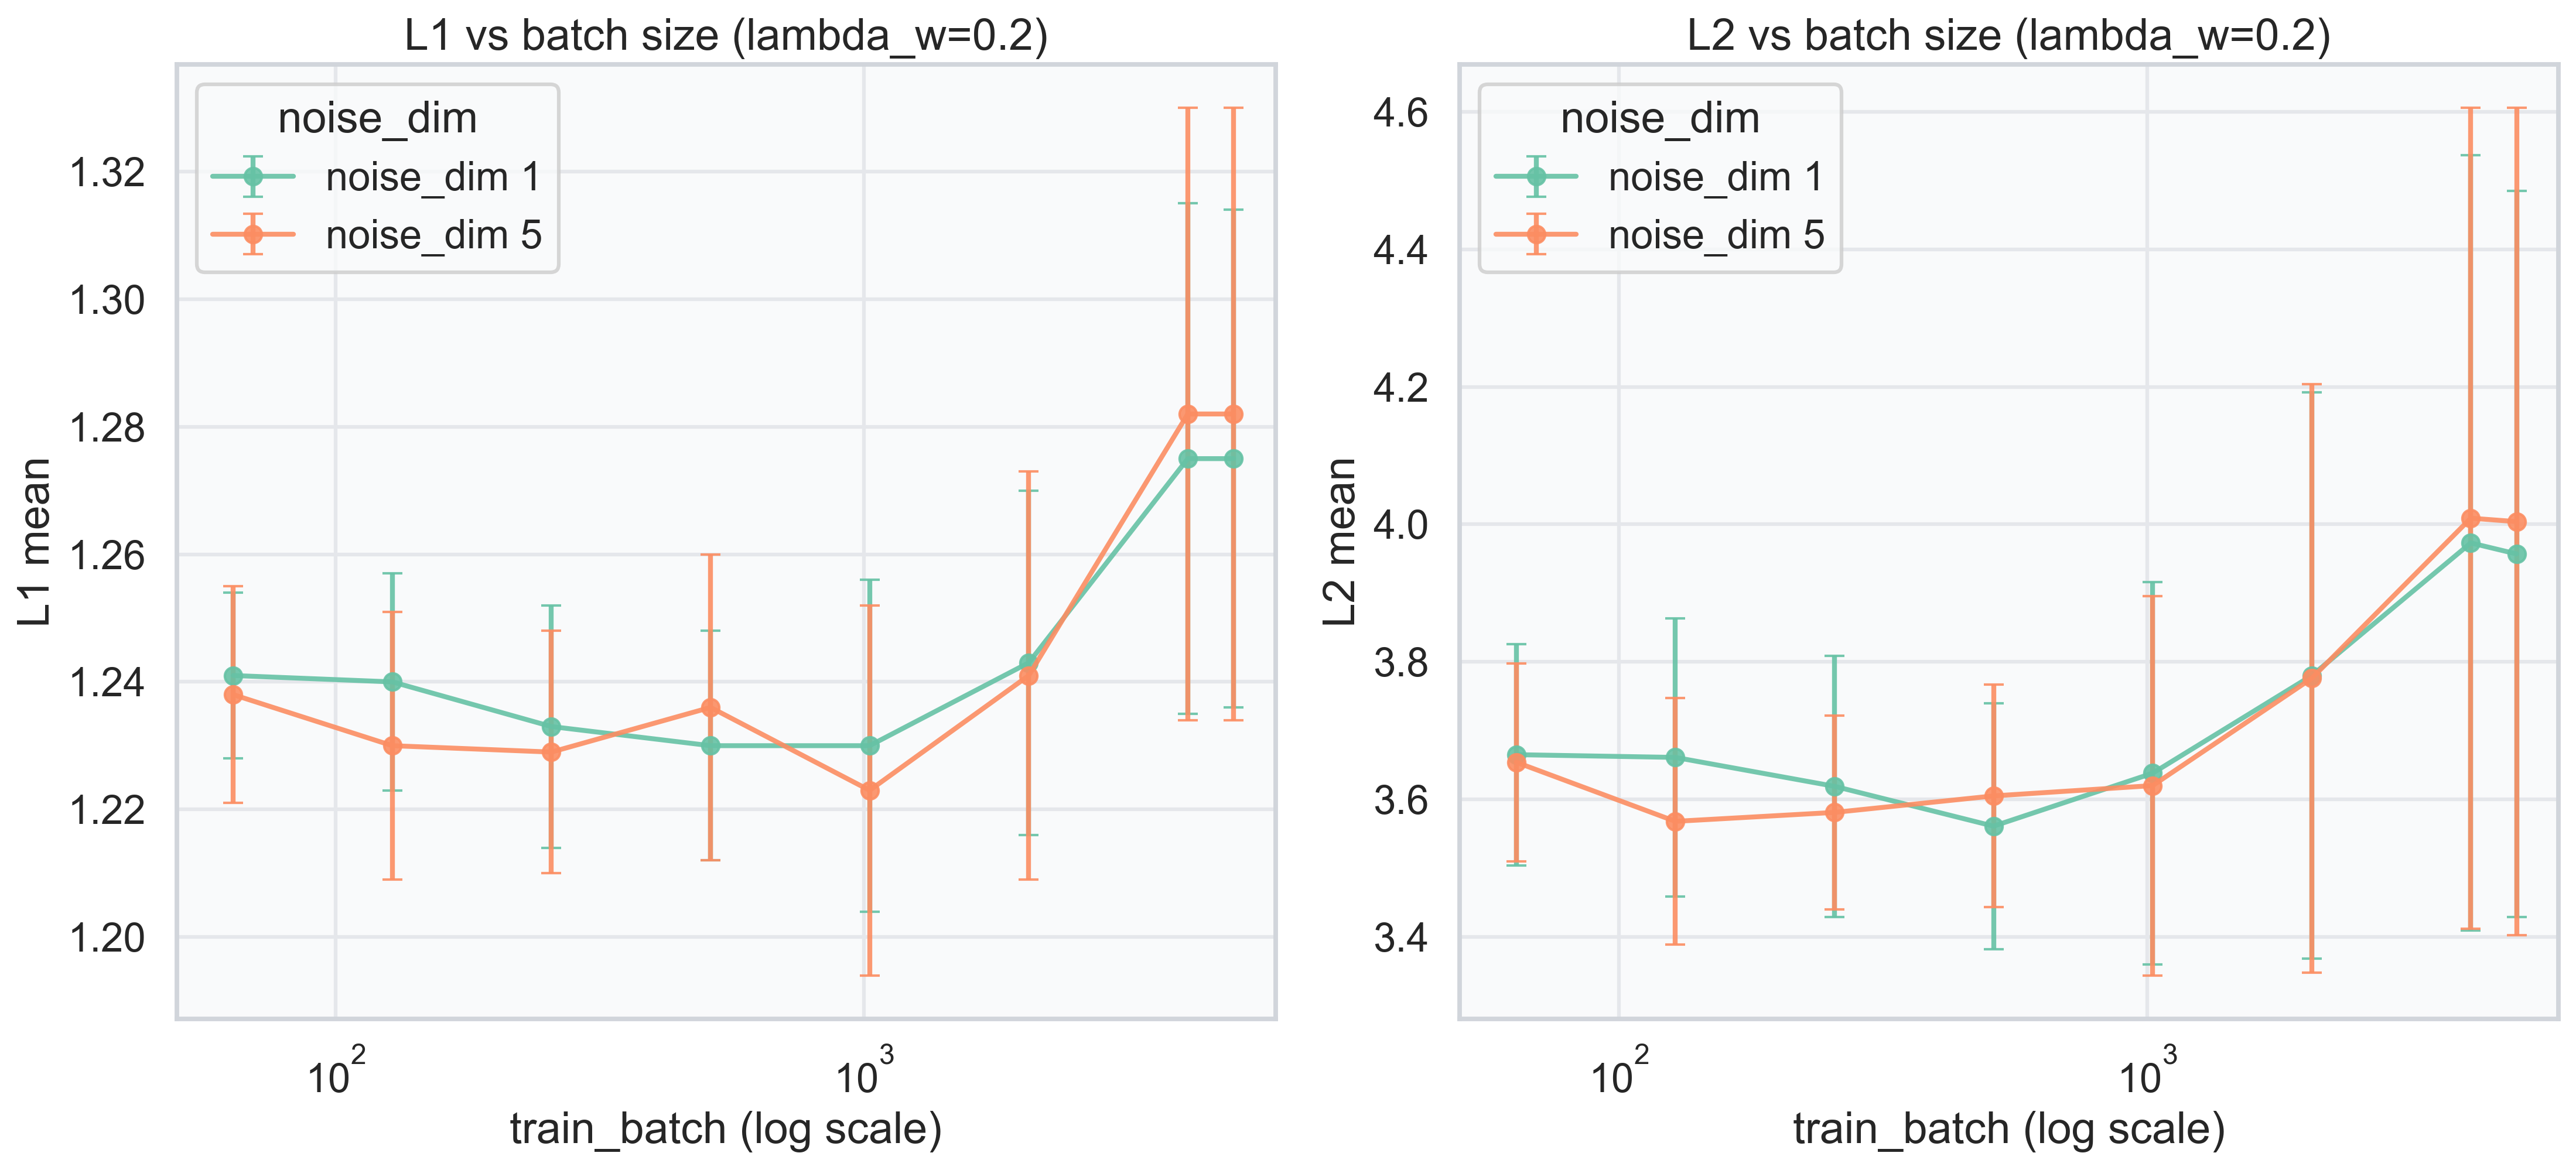

In [62]:
subset = table1[table1['lambda_w'] == 0.2].sort_values('train_batch')
metrics = [('L1_mean', 'L1_sd', 'L1', 1.24), ('L2_mean', 'L2_sd', 'L2', 3.46)]

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

for ax, (mean_col, sd_col, label, official_val) in zip(axes, metrics):
    for nd, sub in subset.groupby('noise_dim'):
        color = noise_palette.get(nd)
        ax.errorbar(
            sub['train_batch'],
            sub[mean_col],
            yerr=sub[sd_col],
            marker='o', linestyle='-', lw=2, markersize=7, capsize=4, alpha=0.9,
            color=color,
            label=f"noise_dim {nd:g}"
        )
    ax.axhline(official_val, linestyle='--', color='#6b7280', lw=1.8, label='official')
    ax.set_xscale('log')
    ax.set_xlim(50, 6000)
    ax.set_xlabel('train_batch (log scale)')
    ax.set_ylabel(f"{label} mean")
    ax.set_title(f"{label} vs batch size (lambda_w=0.2)")
    ax.legend(title='noise_dim')

plt.tight_layout()
plt.show()


## All metrics vs batch size at lambda_w = 0.2
Error bars use the std values inside parentheses from the markdown table.


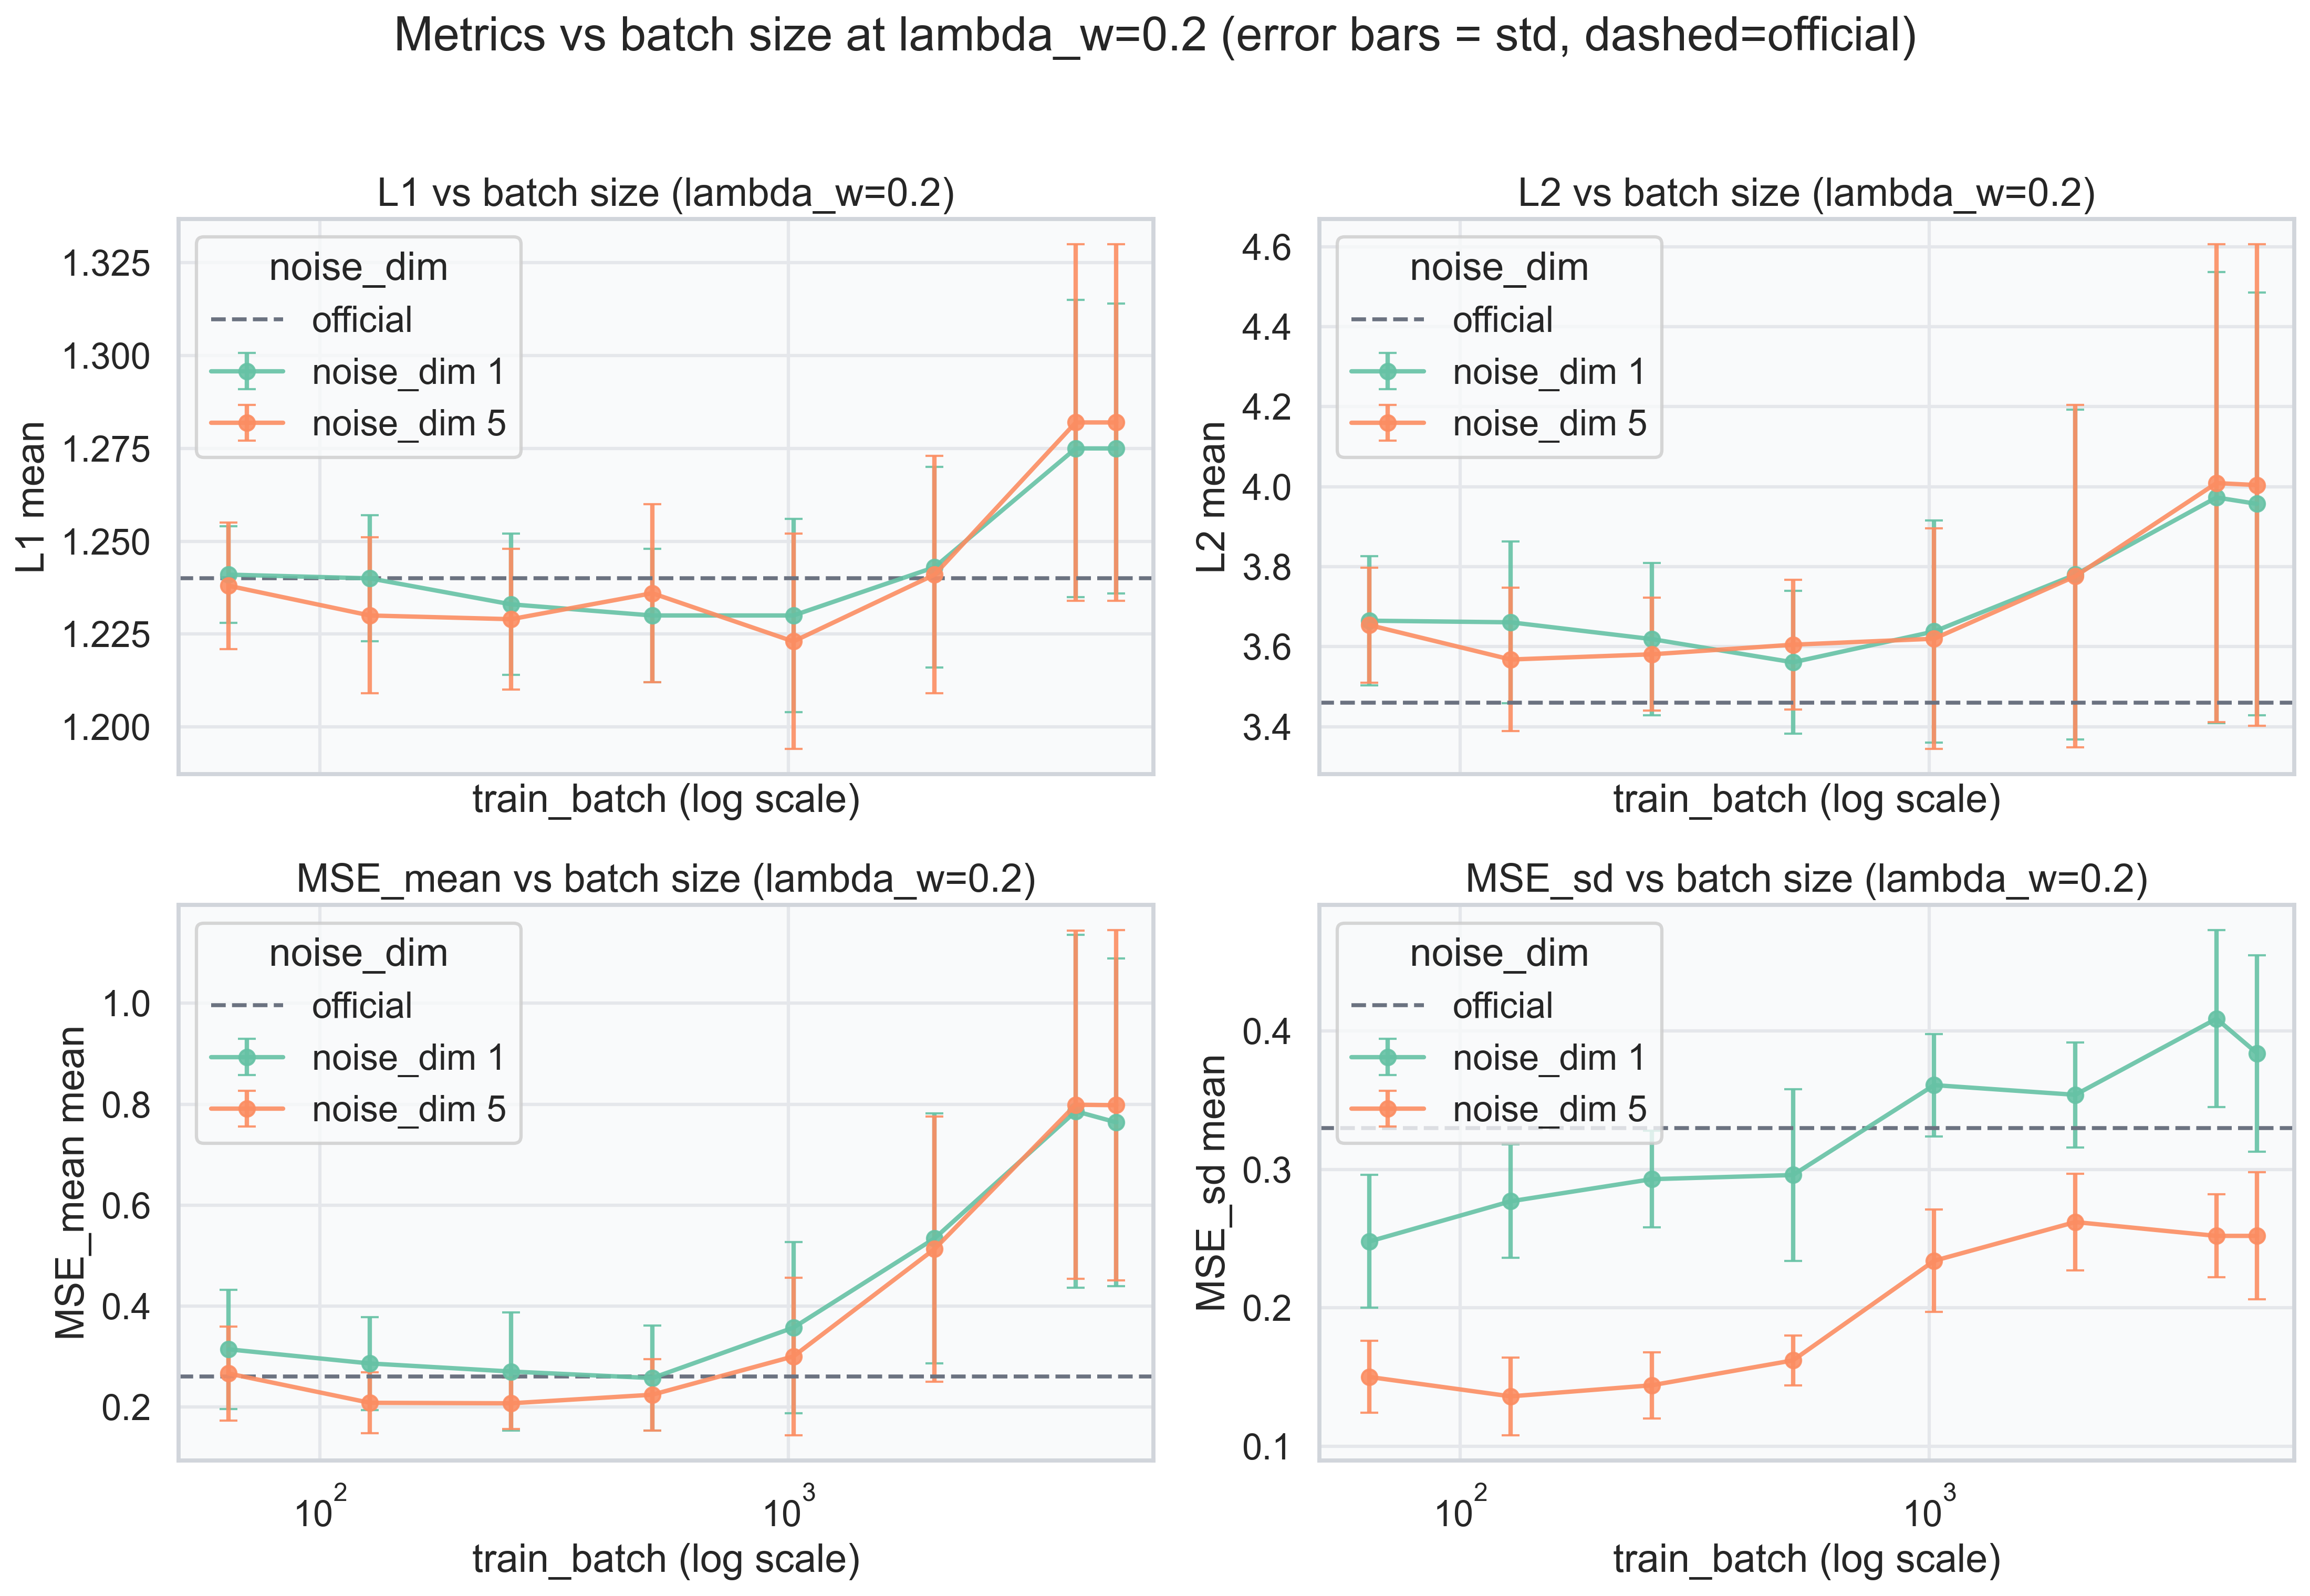

In [76]:
subset = table1[table1['lambda_w'] == 0.2].sort_values('train_batch')
metrics = [
    ('L1_mean', 'L1_sd', 'L1', 1.24),
    ('L2_mean', 'L2_sd', 'L2', 3.46),
    ('MSE_mean_mean', 'MSE_mean_sd', 'MSE_mean', 0.26),
    ('MSE_sd_mean', 'MSE_sd_sd', 'MSE_sd', 0.33),
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()

for ax, (mean_col, sd_col, label, official_val) in zip(axes, metrics):
    for nd, sub in subset.groupby('noise_dim'):
        color = noise_palette.get(nd)
        ax.errorbar(
            sub['train_batch'],
            sub[mean_col],
            yerr=sub[sd_col],
            marker='o', linestyle='-', lw=2, markersize=7, capsize=4, alpha=0.9,
            color=color,
            label=f"noise_dim {nd:g}"
        )
    ax.axhline(official_val, linestyle='--', color='#6b7280', lw=1.8, label='official')
    ax.set_xscale('log')
    ax.set_xlim(50, 6000)
    ax.set_xlabel('train_batch (log scale)')
    ax.set_ylabel(f'{label} mean')
    ax.set_title(f'{label} vs batch size (lambda_w=0.2)')
    ax.legend(title='noise_dim')

fig.suptitle('Metrics vs batch size at lambda_w=0.2 (error bars = std, dashed=official)', y=1.02)
plt.tight_layout()
plt.show()


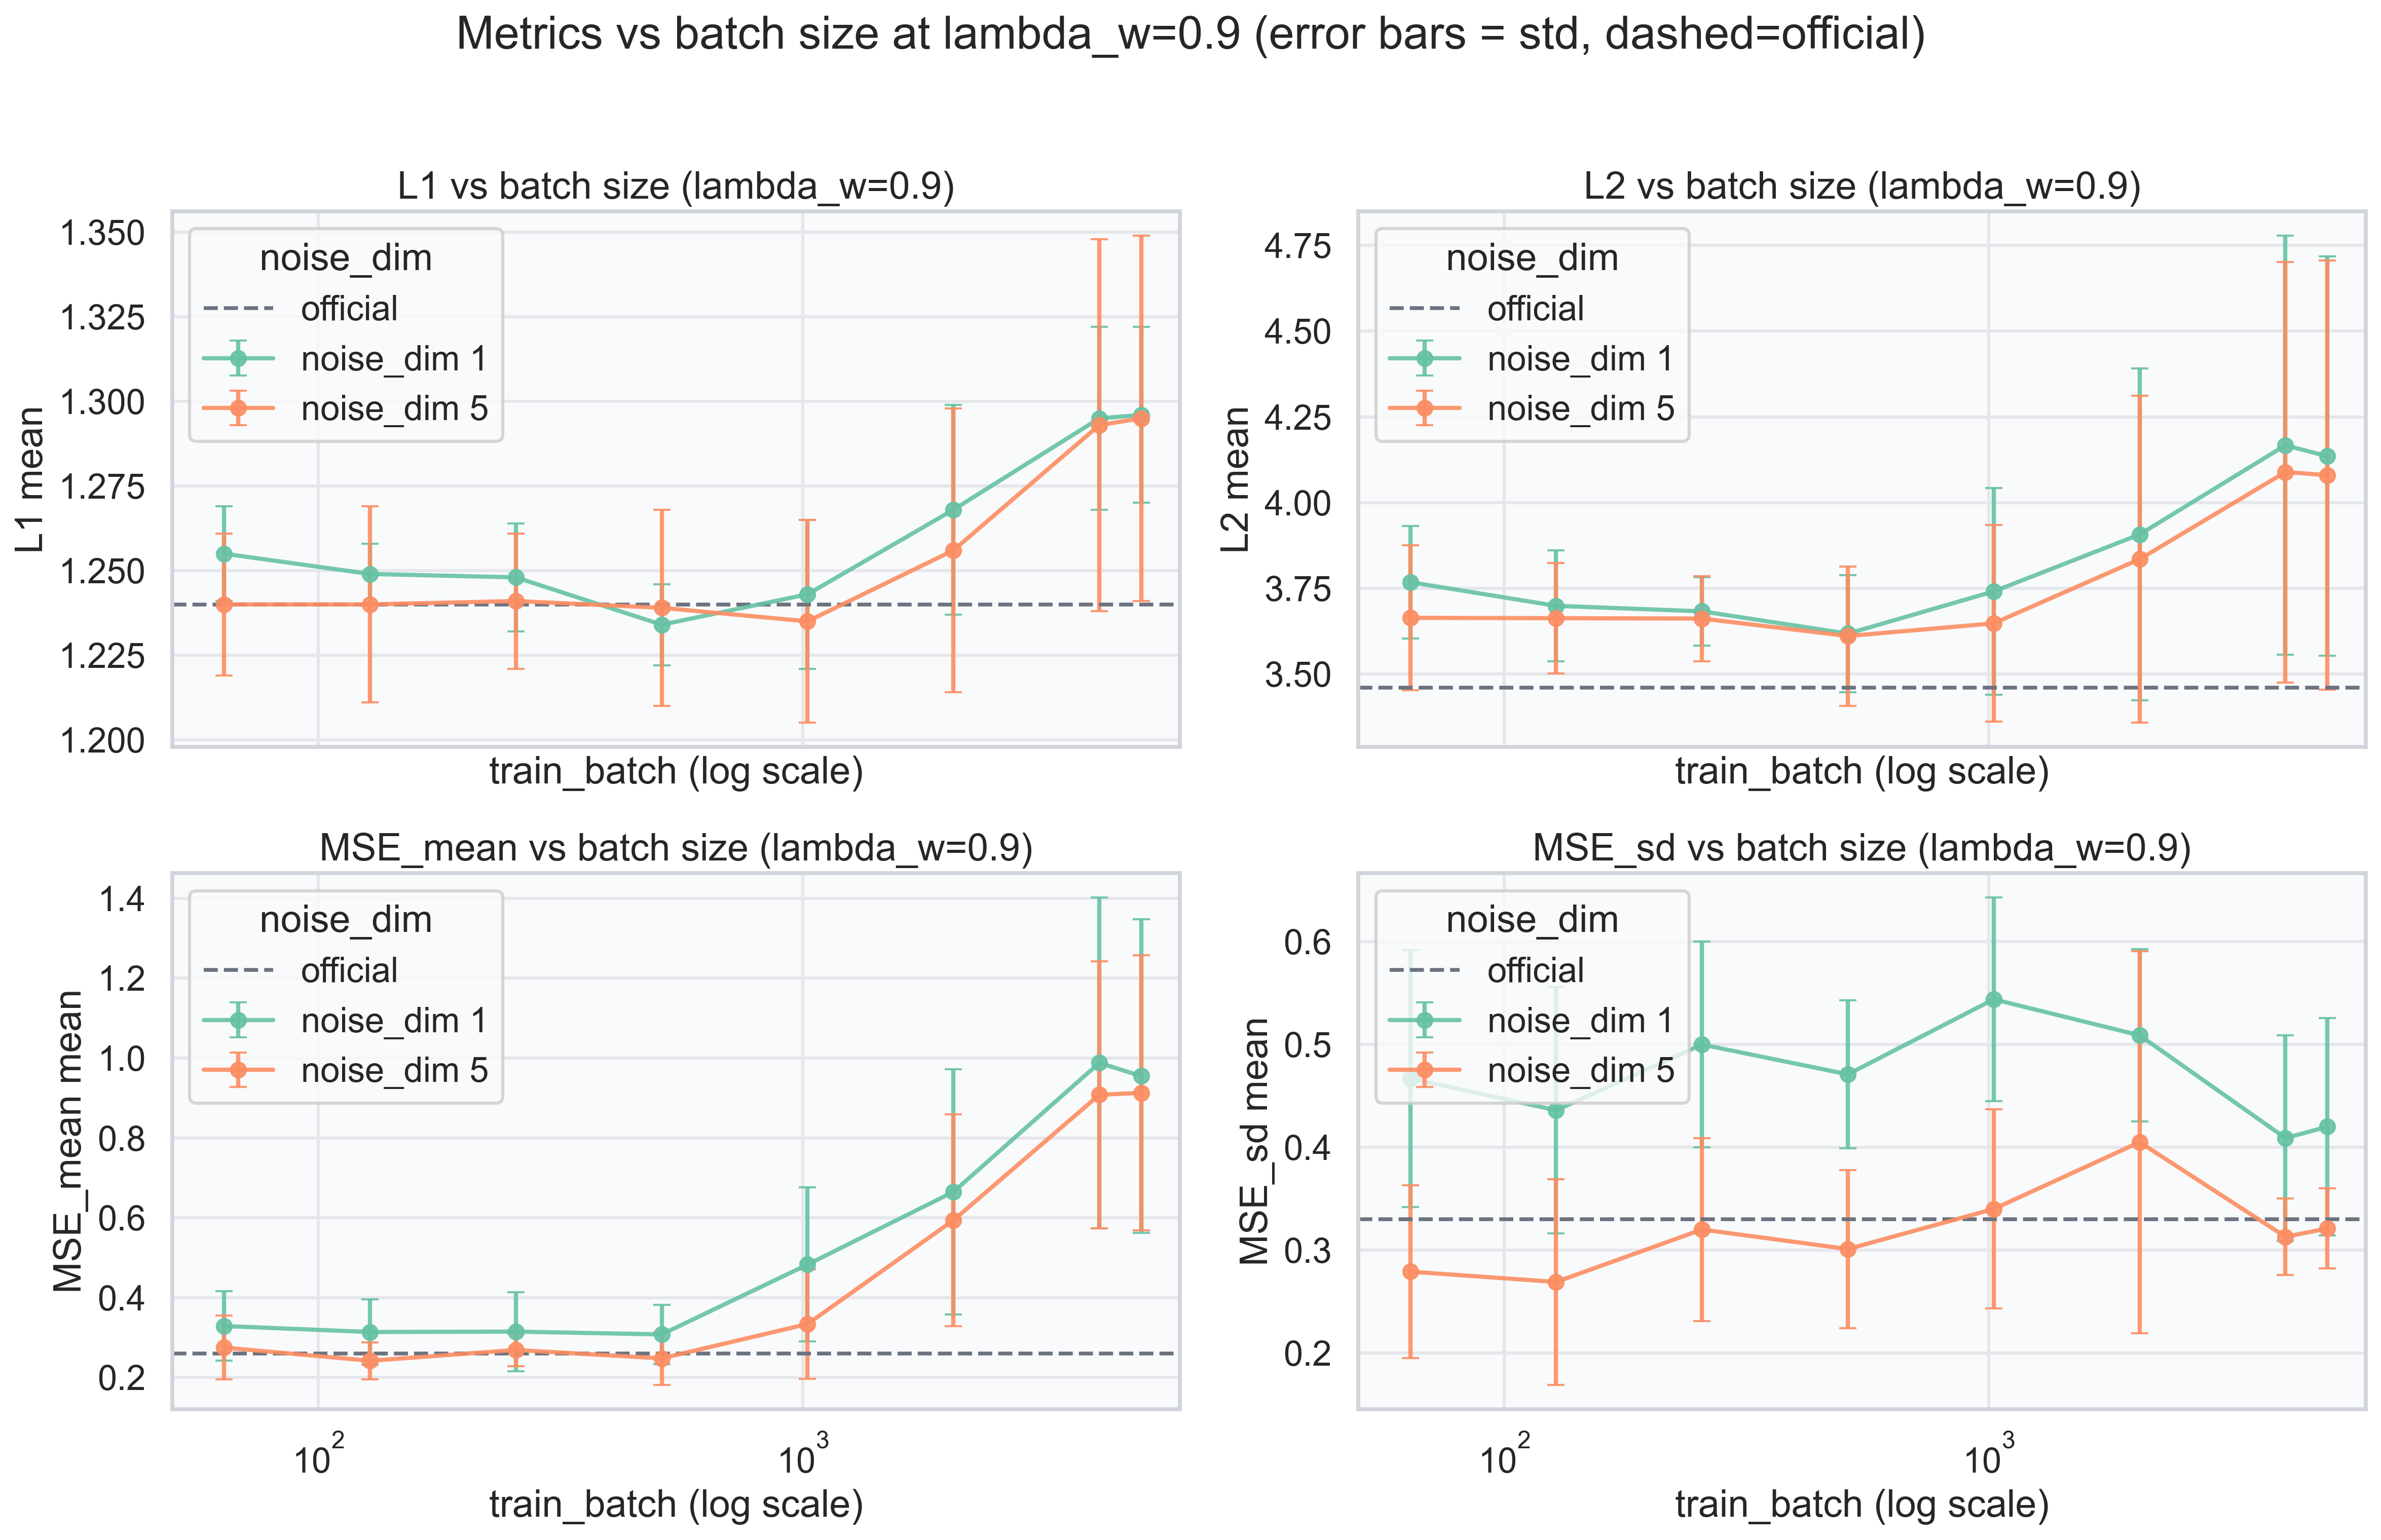

In [81]:
subset = table1[table1['lambda_w'] == 0.9].sort_values('train_batch')
metrics = [
    ('L1_mean', 'L1_sd', 'L1', 1.24),
    ('L2_mean', 'L2_sd', 'L2', 3.46),
    ('MSE_mean_mean', 'MSE_mean_sd', 'MSE_mean', 0.26),
    ('MSE_sd_mean', 'MSE_sd_sd', 'MSE_sd', 0.33),
]

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()

for ax, (mean_col, sd_col, label, official_val) in zip(axes, metrics):
    for nd, sub in subset.groupby('noise_dim'):
        color = noise_palette.get(nd)
        ax.errorbar(
            sub['train_batch'],
            sub[mean_col],
            yerr=sub[sd_col],
            marker='o', linestyle='-', lw=2, markersize=7, capsize=4, alpha=0.9,
            color=color,
            label=f"noise_dim {nd:g}"
        )
    ax.axhline(official_val, linestyle='--', color='#6b7280', lw=1.8, label='official')
    ax.set_xscale('log')
    ax.set_xlabel('train_batch (log scale)')
    ax.set_xlim(50, 6000)
    ax.set_ylabel(f'{label} mean')
    ax.set_title(f'{label} vs batch size (lambda_w=0.9)')
    ax.legend(title='noise_dim')

fig.suptitle('Metrics vs batch size at lambda_w=0.9 (error bars = std, dashed=official)', y=1.02)
plt.tight_layout()
plt.show()


## All metrics vs lambda_w (train_batch = 128)
Filter to batch size 128 and sweep lambda_w; error bars are std from the parentheses.


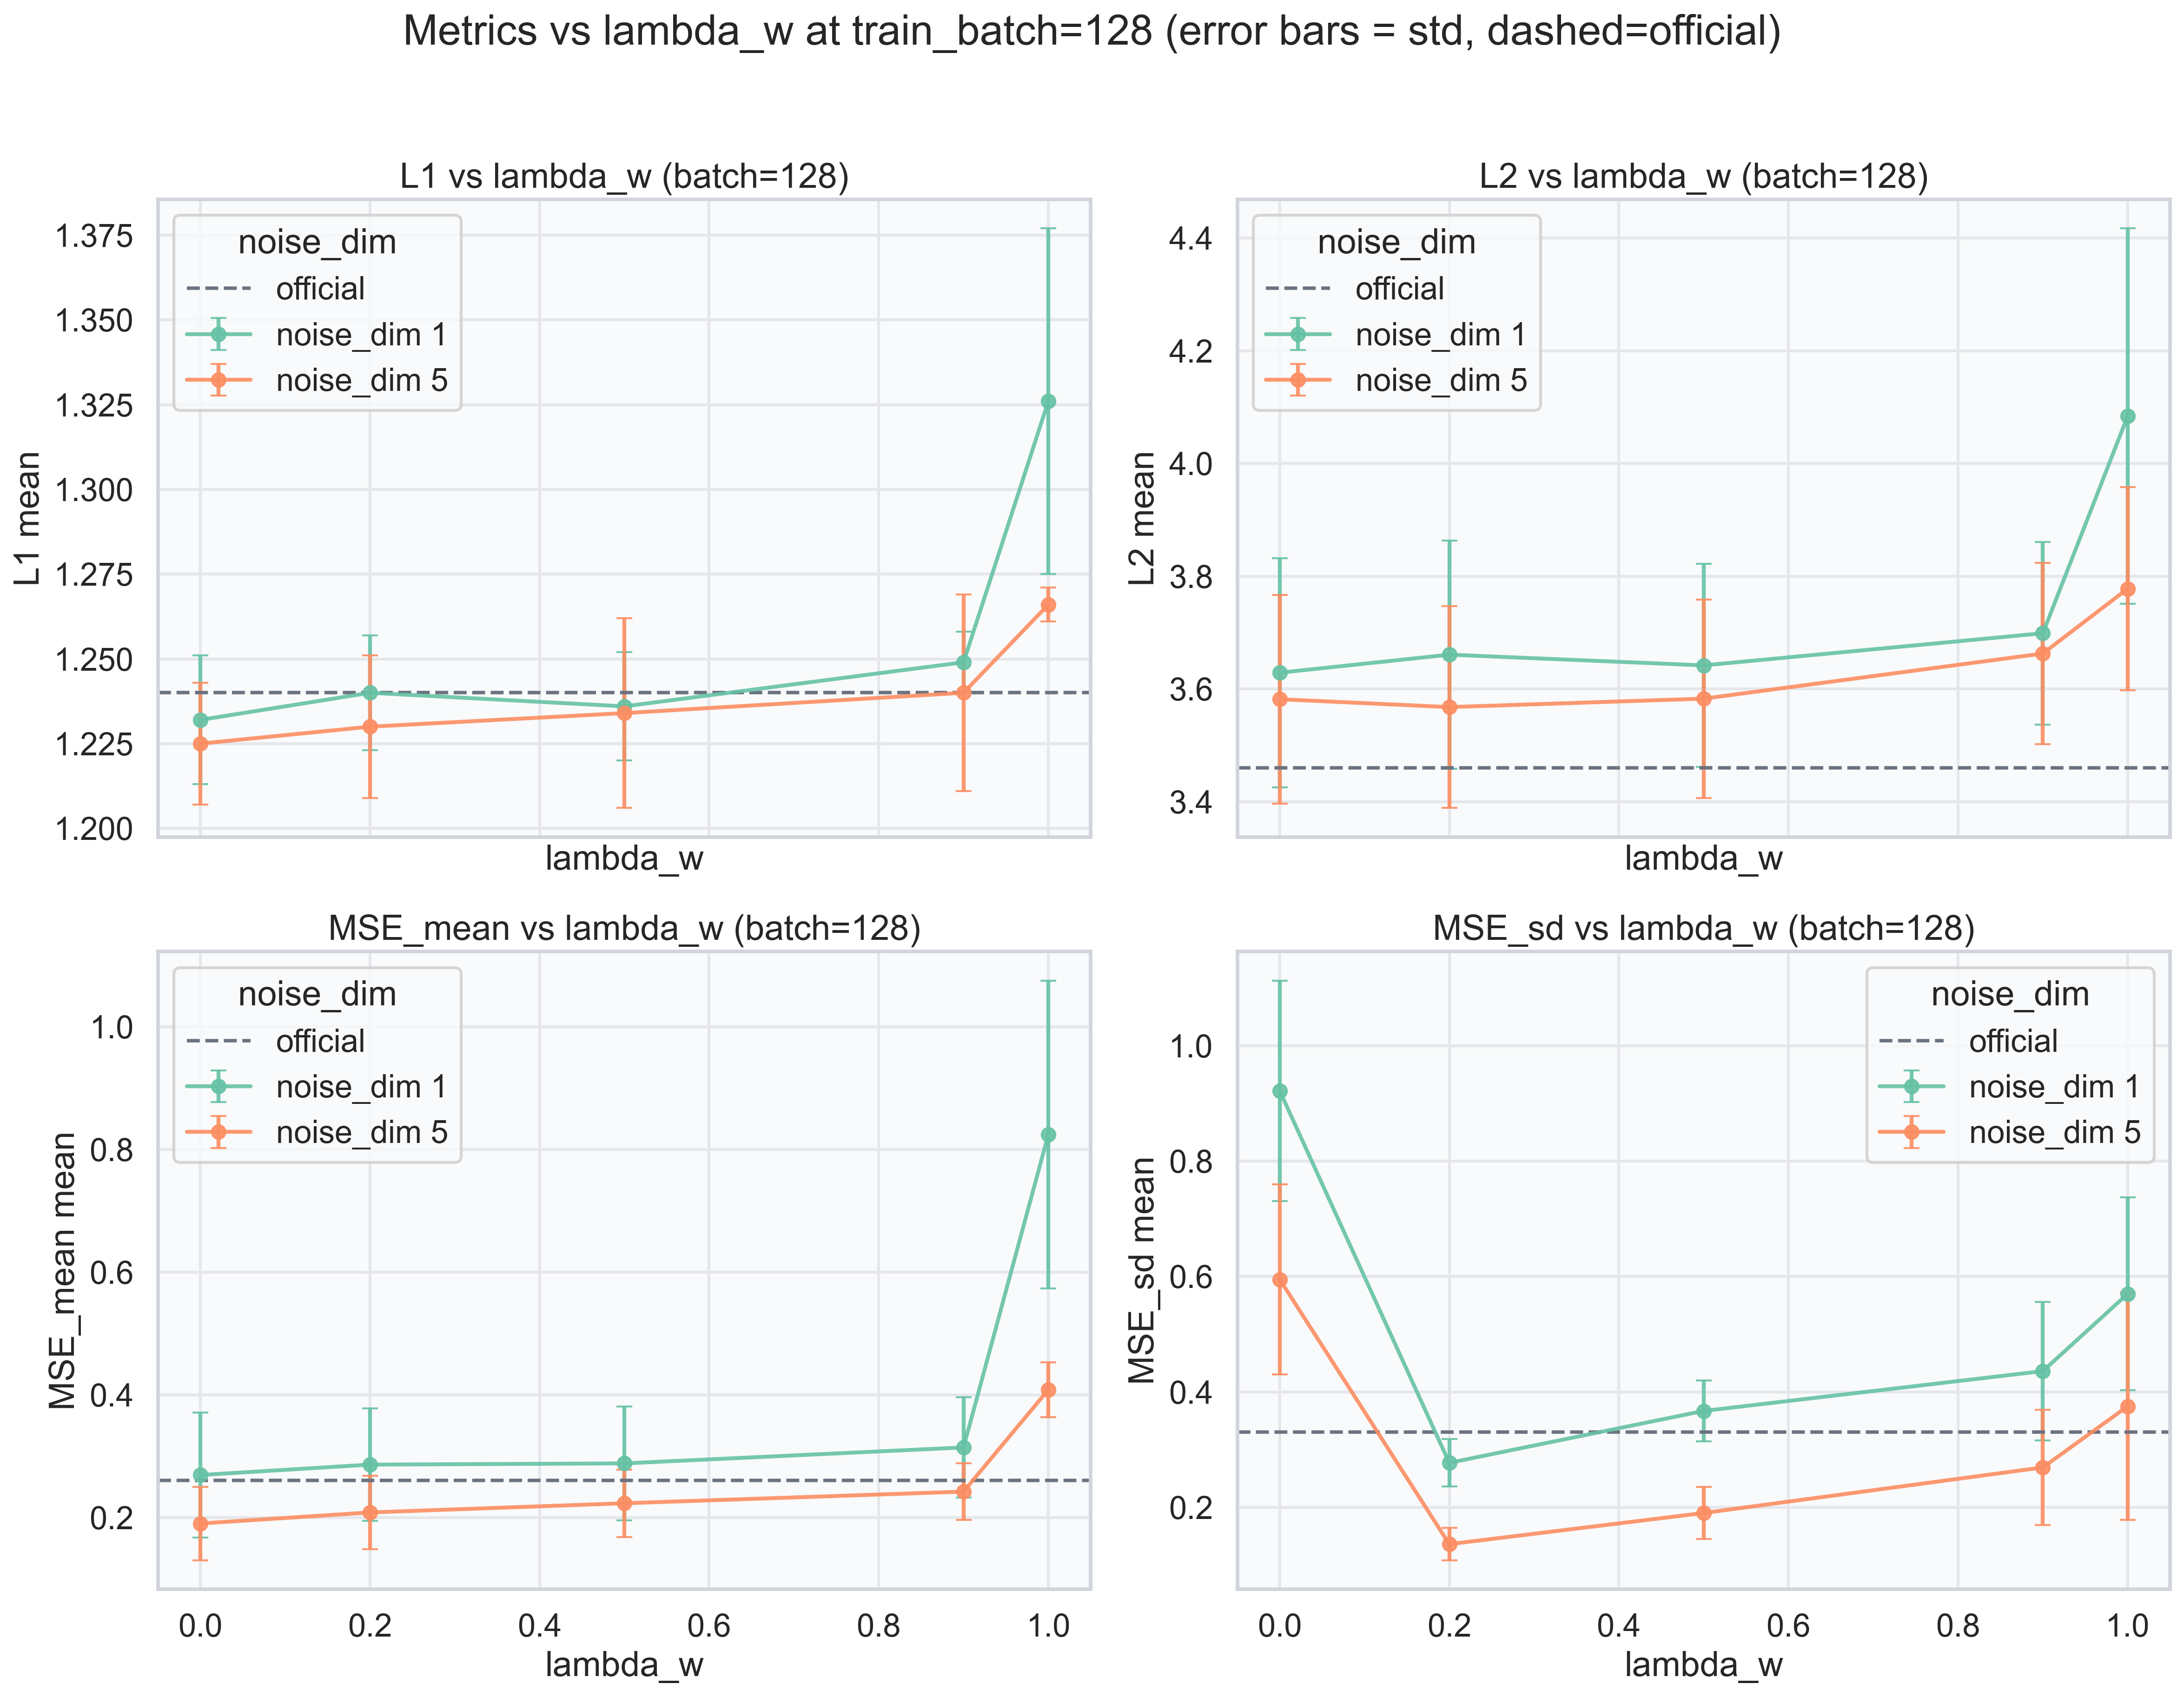

In [78]:
subset = table1[table1['train_batch'] == 128].sort_values('lambda_w')
metrics = [
    ('L1_mean', 'L1_sd', 'L1', 1.24),
    ('L2_mean', 'L2_sd', 'L2', 3.46),
    ('MSE_mean_mean', 'MSE_mean_sd', 'MSE_mean', 0.26),
    ('MSE_sd_mean', 'MSE_sd_sd', 'MSE_sd', 0.33),
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for ax, (mean_col, sd_col, label, official_val) in zip(axes, metrics):
    for nd, sub in subset.groupby('noise_dim'):
        color = noise_palette.get(nd)
        ax.errorbar(
            sub['lambda_w'],
            sub[mean_col],
            yerr=sub[sd_col],
            marker='o', linestyle='-', lw=2, markersize=7, capsize=4, alpha=0.9,
            color=color,
            label=f"noise_dim {nd:g}"
        )
    ax.axhline(official_val, linestyle='--', color='#6b7280', lw=1.8, label='official')
    ax.set_xlabel('lambda_w')
    ax.set_ylabel(f'{label} mean')
    ax.set_title(f'{label} vs lambda_w (batch=128)')
    ax.legend(title='noise_dim')

fig.suptitle('Metrics vs lambda_w at train_batch=128 (error bars = std, dashed=official)', y=1.02)
plt.tight_layout()
plt.show()


## Quantiles vs lambda_w (train_batch = 128)
Uses Q05/Q25/Q50/Q75/Q95 from the quantile table; error bars are the std values in parentheses.


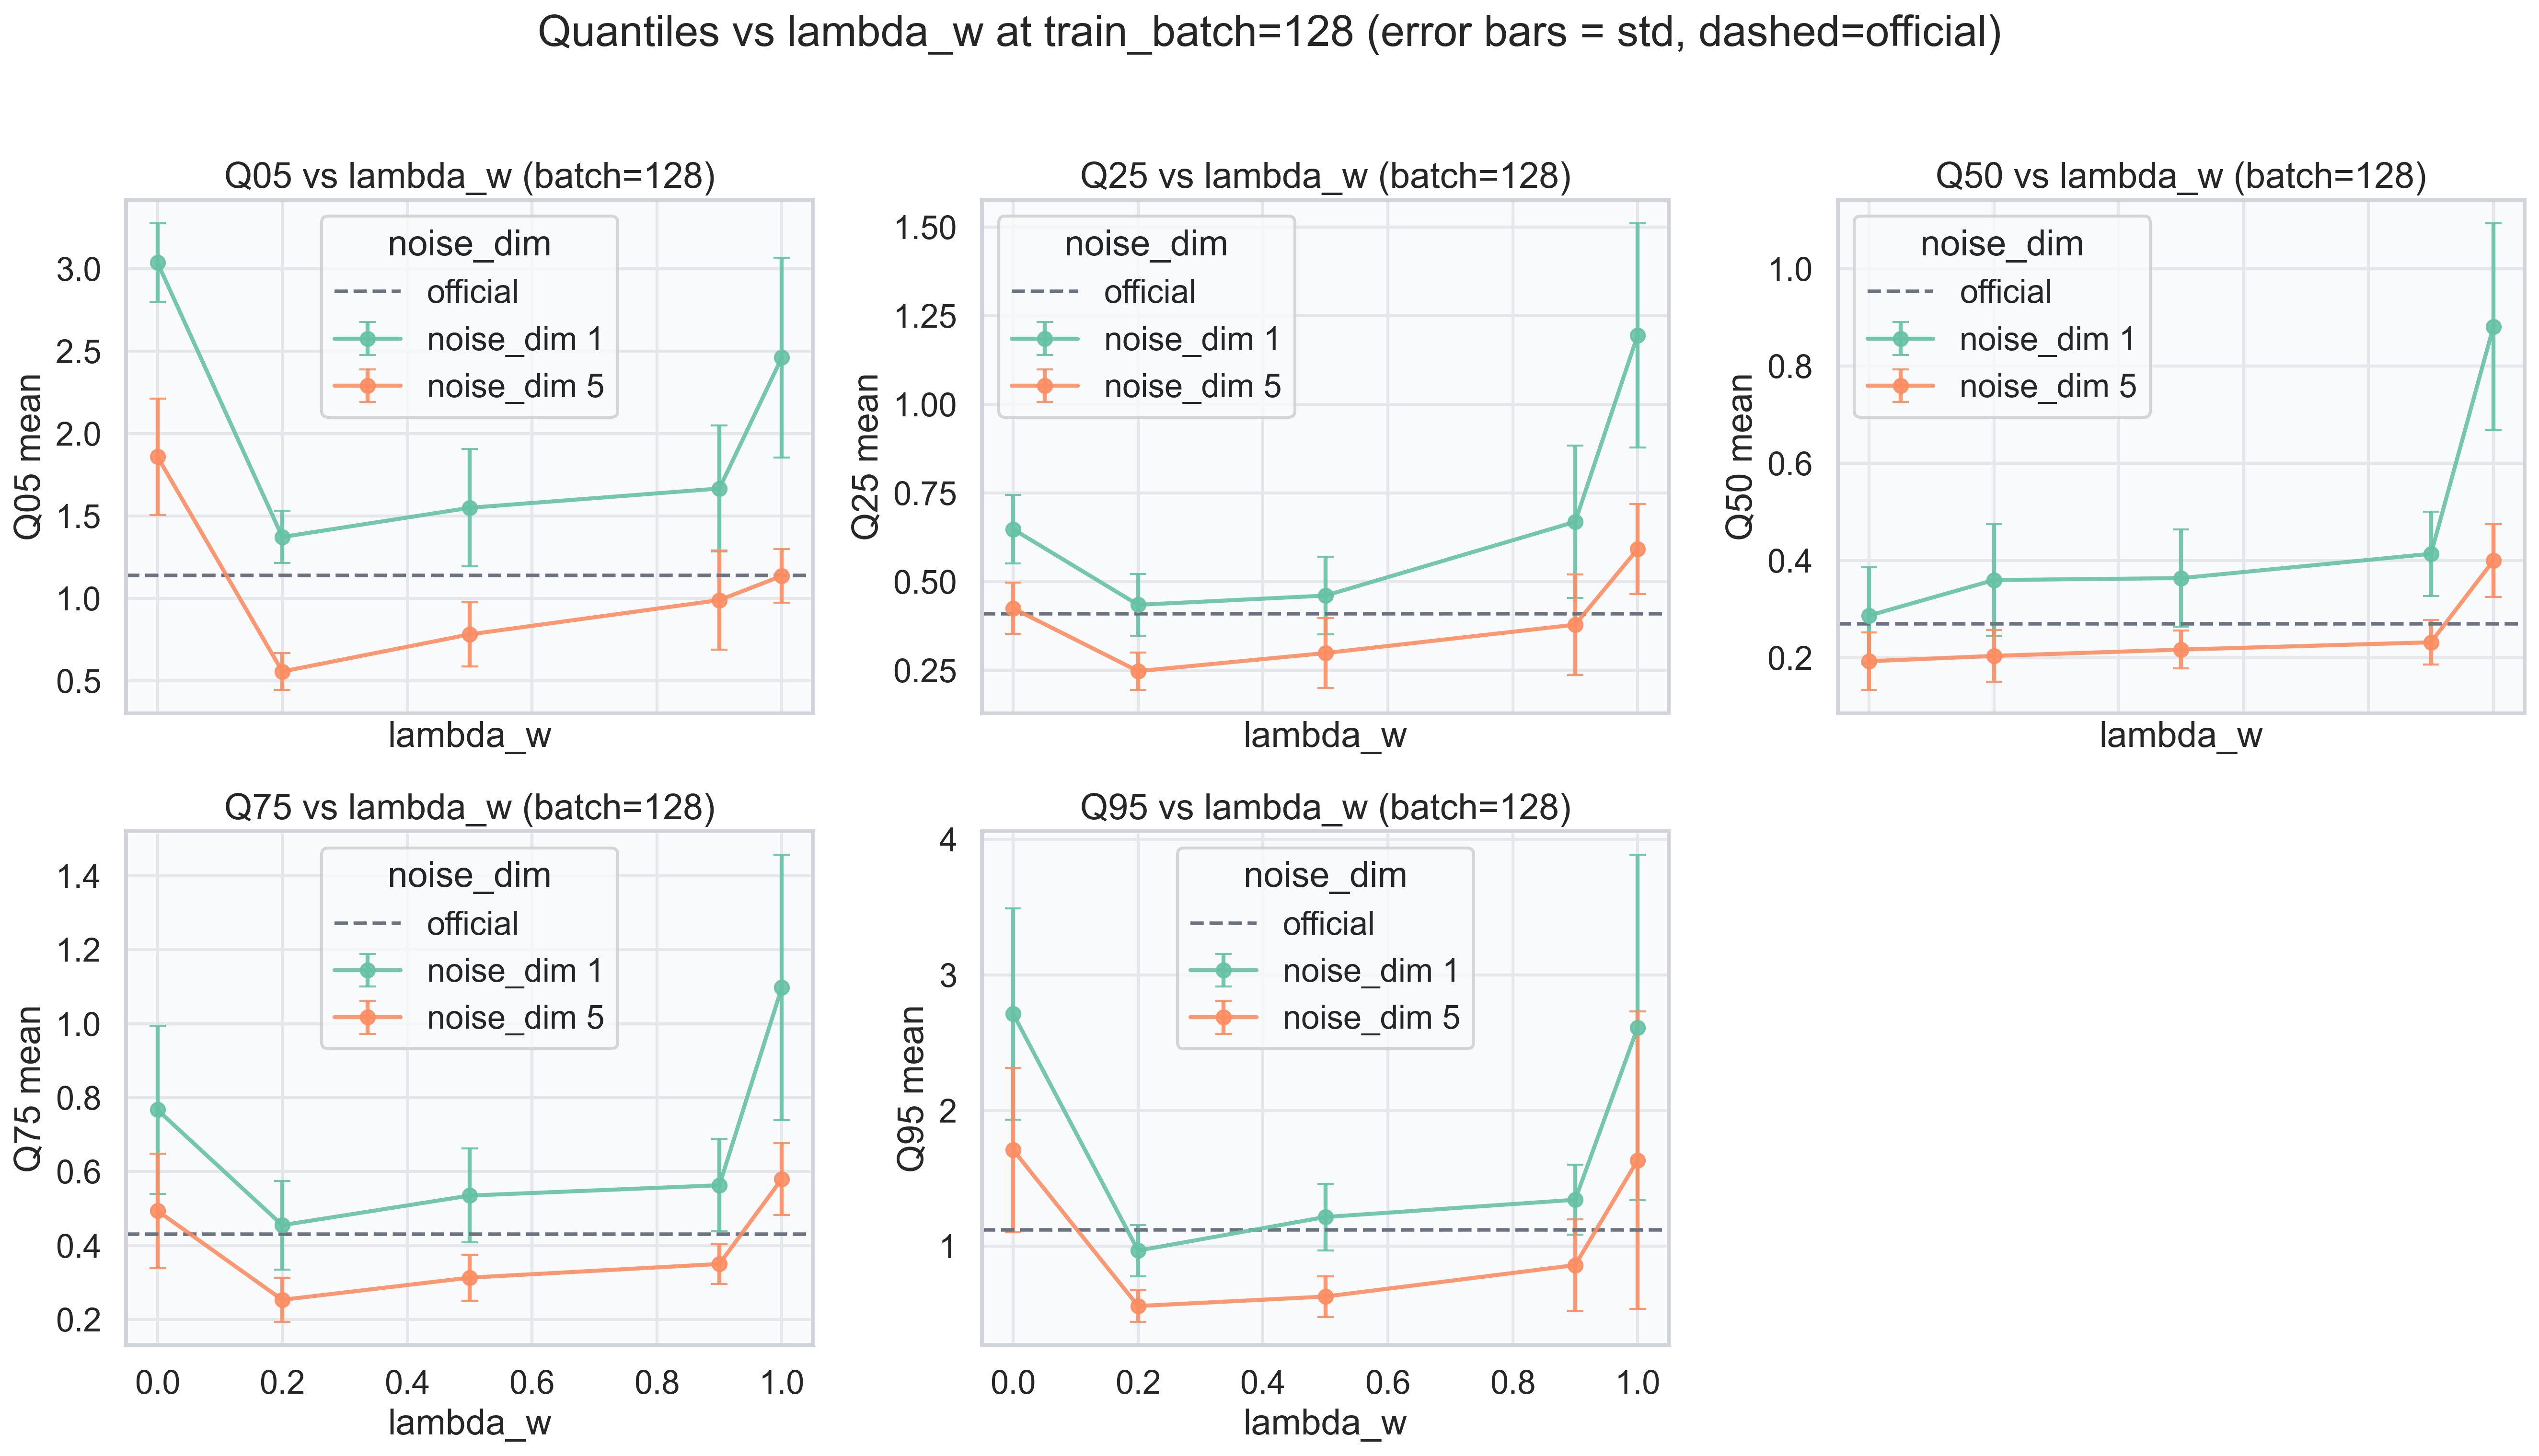

In [66]:
subset_q = table2[table2["train_batch"] == 128].sort_values("lambda_w")
quantiles = ["Q05", "Q25", "Q50", "Q75", "Q95"]
official = {"Q05": 1.14, "Q25": 0.41, "Q50": 0.27, "Q75": 0.43, "Q95": 1.12}

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for ax, q in zip(axes, quantiles):
    mean_col = f"{q}_mean"
    sd_col = f"{q}_sd"
    for nd, sub in subset_q.groupby("noise_dim"):
        color = noise_palette.get(nd)
        ax.errorbar(
            sub["lambda_w"],
            sub[mean_col],
            yerr=sub[sd_col],
            marker="o",
            linestyle="-",
            lw=2,
            markersize=7,
            capsize=4,
            alpha=0.9,
            color=color,
            label=f"noise_dim {nd:g}",
        )
    ax.axhline(official[q], linestyle="--", color="#6b7280", lw=1.8, label="official")
    ax.set_xlabel("lambda_w")
    ax.set_ylabel(f"{q} mean")
    ax.set_title(f"{q} vs lambda_w (batch=128)")
    ax.legend(title="noise_dim")

# hide unused last axis if present
if len(axes) > len(quantiles):
    for ax in axes[len(quantiles):]:
        ax.axis("off")

fig.suptitle("Quantiles vs lambda_w at train_batch=128 (error bars = std, dashed=official)", y=1.02)
plt.tight_layout()
plt.show()


## Q25 vs batch size at lambda_w = 0.2
Plots Q25 mean with std error bars across train_batch, colored by noise_dim (log x-axis).


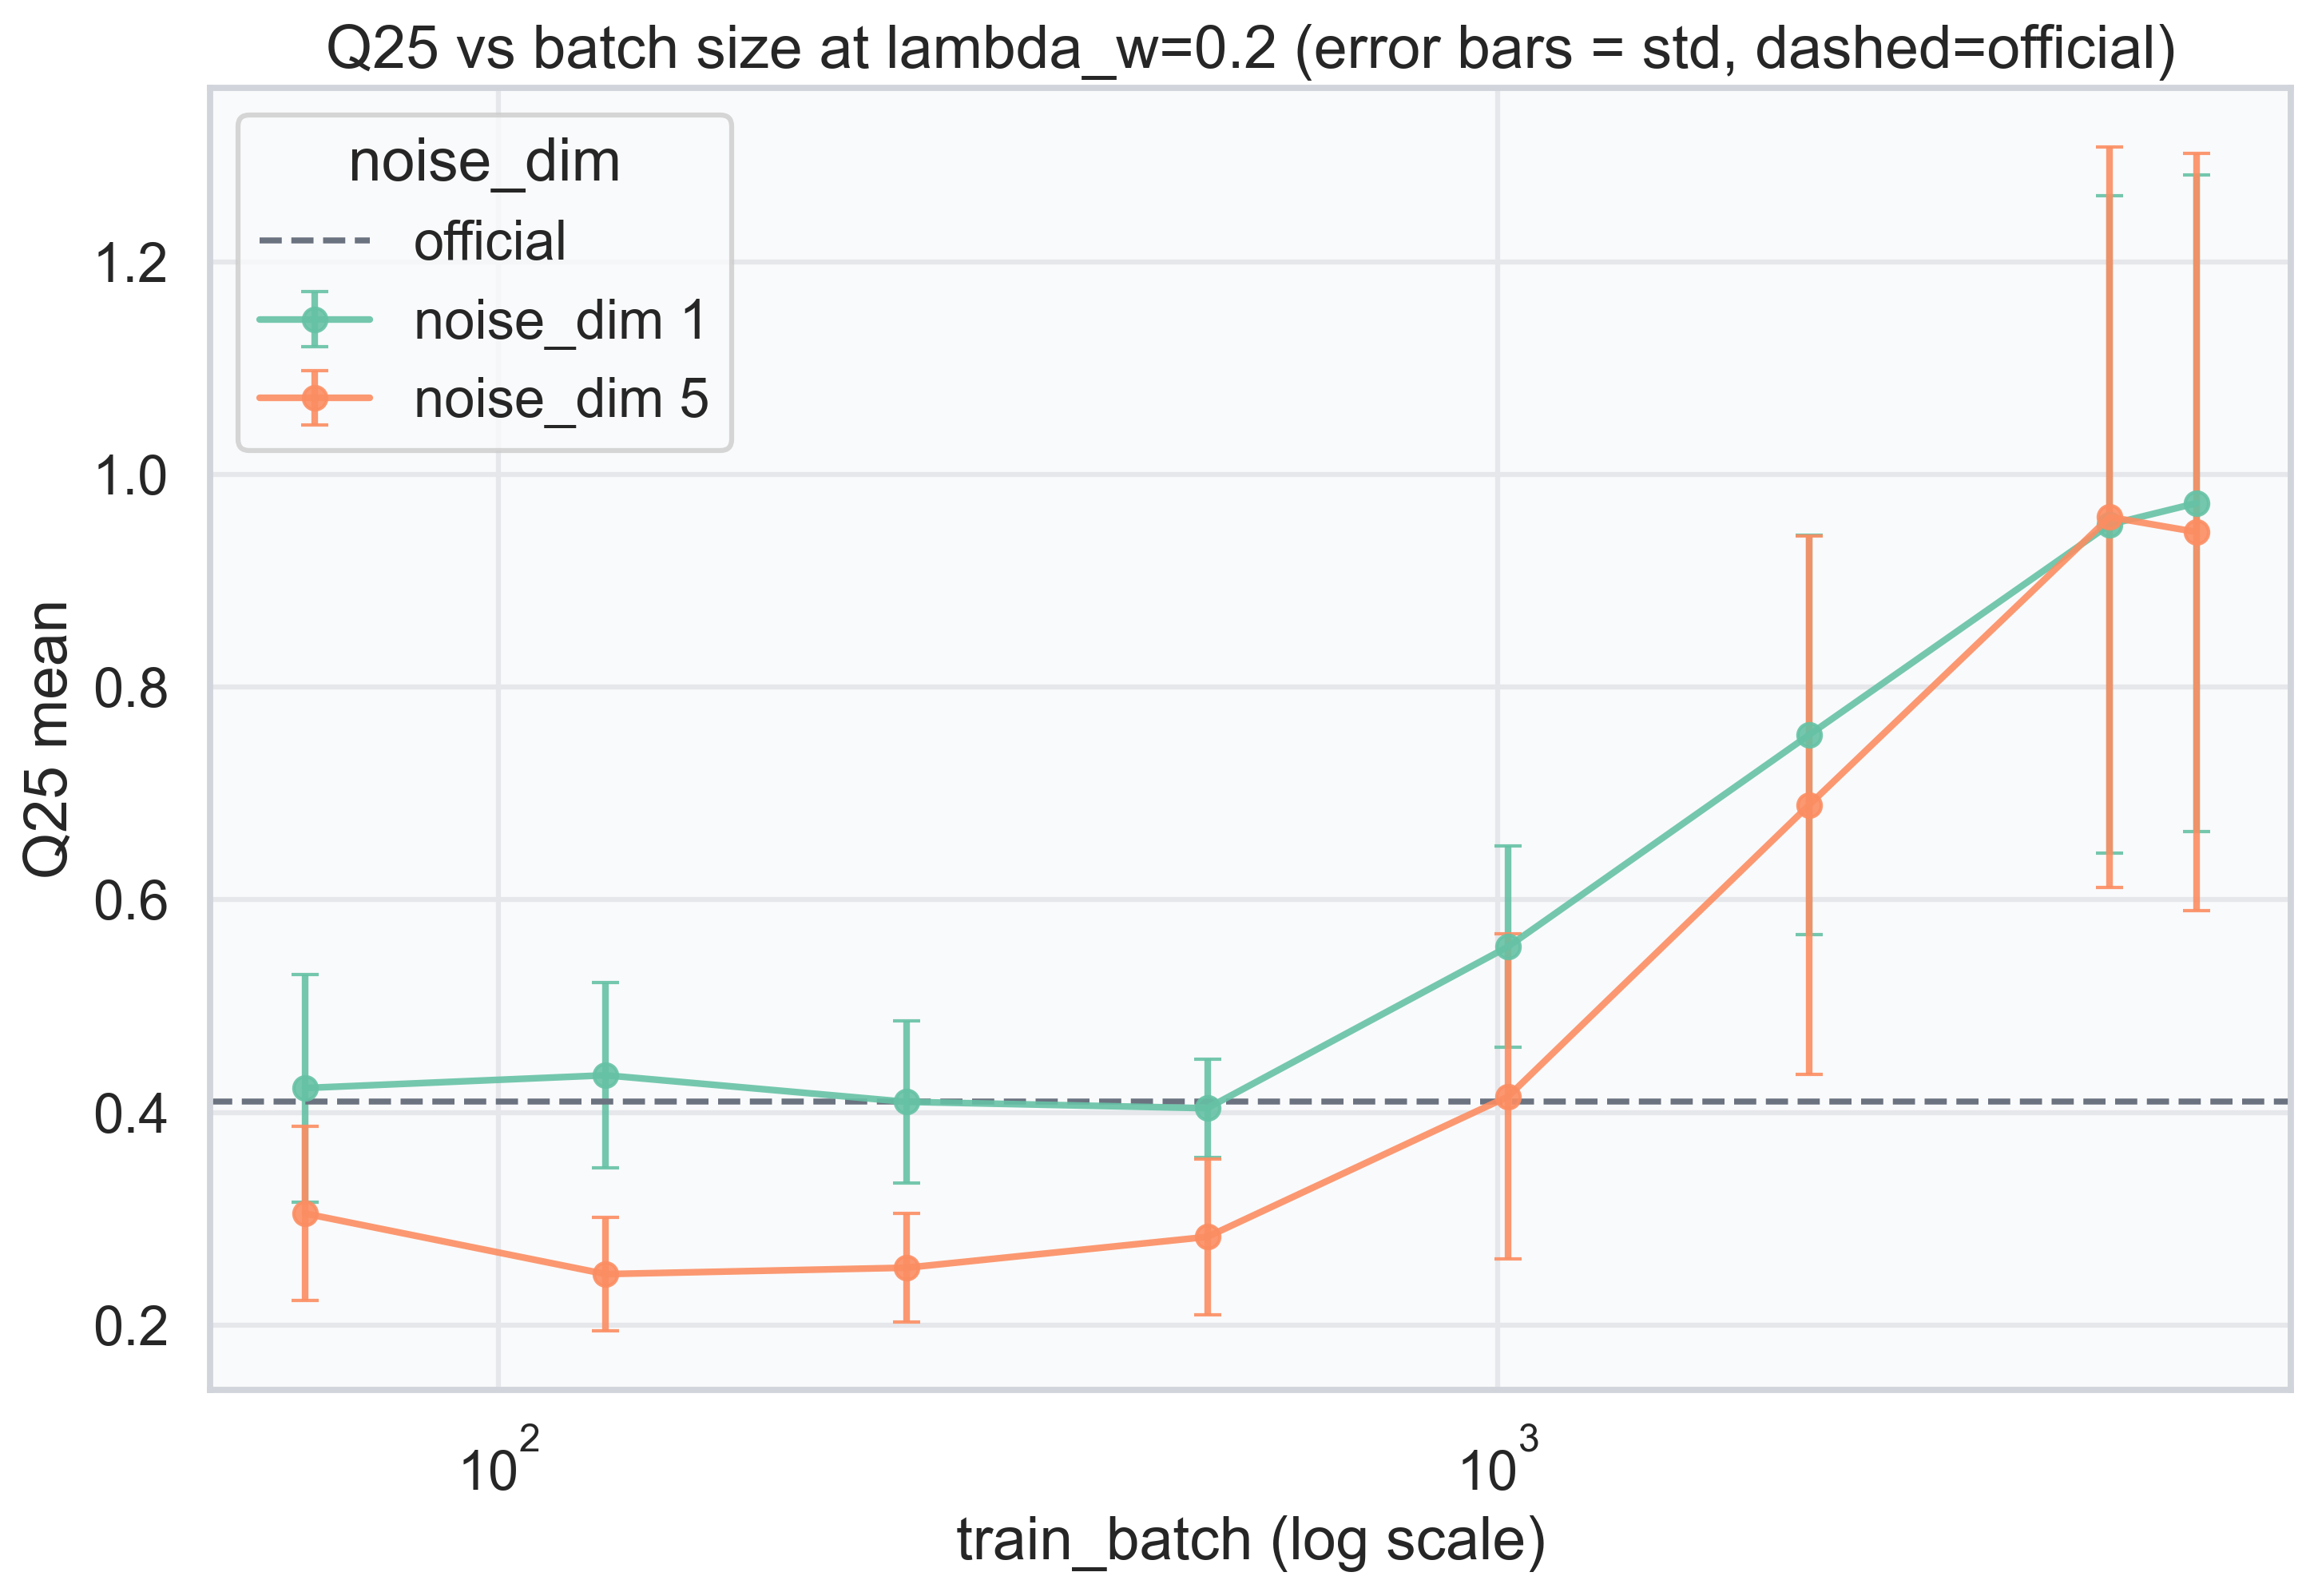

In [71]:
subset_q25 = table2[table2["lambda_w"] == 0.2].sort_values("train_batch")
official_q25 = 0.41

fig, ax = plt.subplots(figsize=(10, 7))
for nd, sub in subset_q25.groupby("noise_dim"):
    color = noise_palette.get(nd)
    ax.errorbar(
        sub["train_batch"],
        sub["Q25_mean"],
        yerr=sub["Q25_sd"],
        marker="o",
        linestyle="-",
        lw=2,
        markersize=7,
        capsize=4,
        alpha=0.9,
        color=color,
        label=f"noise_dim {nd:g}",
    )

ax.axhline(official_q25, linestyle="--", color="#6b7280", lw=1.8, label="official")
ax.set_xscale("log")
ax.set_xlabel("train_batch (log scale)")
ax.set_ylabel("Q25 mean")
ax.set_title("Q25 vs batch size at lambda_w=0.2 (error bars = std, dashed=official)")
ax.legend(title="noise_dim")
plt.tight_layout()
plt.show()
